<a href="https://colab.research.google.com/github/AlexandreAdam/ProbabilisticGraphicalModels/blob/master/hw2_AlexandreAdam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6269 - Homework 2 - Linear Classification

**Due**: Tuesday, October 13, 2020

#### Name: Alexandre Adam
#### Student ID: 20090755
#### Collaborators: Olivier Vincent, Ronan Legin



### Introduction

In this assignment you will compare the performance of several algorithm on some synthetic classification tasks. The assignment consists of two parts: 1) a derivation of the estimators for the Fisher LDA with general covariance matrix derivation and 2) the implementation of several classification algorithms.

### Tasks
0.   Get your own copy of this file via "File > Save a copy in Drive...",
1.   Fill your personal information and collaborators at the top of this assignment, and rename the notebook accordingly, e.g., `hw2_thomasBayes.ipynb`
2.   Read the instructions provided on each section and cell carefully,
3.   Answer the section **Math Questions on Fisher LDA**,
4.   Implement the requested algorithms in section **Playground** following the example provided in dummy_model`,
5.   In section **Model Comparison**, for each of the datasets:
    *   use the training data to estimate the parameters of each of the 4 algorithms,
    *   plot the corresponding estimated decision boundary and the training set using the function `plot_results`, 
    *   compute the training and test accuracy and fill the table in each section by hand,
    *   compare the performance of each of the algorithms and provide an explanation for your observations based on, for example, their accuracy, overfitting/generalization properties, whether the assumptions of each algorithms are satisfied by the data, etc. 
    
**Important**: You are allowed to collaborate with other students in both the math and coding parts of this assignment. However, the answers provided here must reflect your individual work. For that reason, you are not allowed to share this notebook, except for your submission to the TA for grading. **Don't forget to pin and save the version of the notebook you want to be graded on!**

In [7]:
!wget http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A20/notes/hwk2data.zip
!unzip hwk2data.zip

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

--2020-10-26 04:05:08--  http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A20/notes/hwk2data.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70575 (69K) [application/zip]
Saving to: ‘hwk2data.zip’

hwk2data.zip        100%[===================>]  68.92K  --.-KB/s    in 0.05s   

2020-10-26 04:05:08 (1.26 MB/s) - ‘hwk2data.zip’ saved [70575/70575]

Archive:  hwk2data.zip
  inflating: hwk2data/classificationA.test  
  inflating: hwk2data/classificationA.train  
  inflating: hwk2data/classificationB.test  
  inflating: hwk2data/classificationB.train  
  inflating: hwk2data/classificationC.test  
  inflating: hwk2data/classificationC.train  


You get 3 different datasets (**A**, **B**, **C**) with a training and test set for each, i.e., 6 sets in total. Each row represents a sample of data $(x_i, y_i)$. There are three columns: the first two give the coordinates for $x_i \in \mathbb{R}^2$; the third column gives the class label $y_i \in \{0, 1\}$. The datasets are all generated from some kind of mixture of Gaussians generative model. The train and test sets are generated from the same distribution for each types of dataset. 

To help your interpretation, we give you the actual
generating process. However, keep in mind that normally we would not know the information about the generating process. In this
assignment, we will compare different classification approaches.
*  **Dataset A**: the class-conditionals for this dataset are Gaussians with different means, but with a shared covariance matrix $\Sigma$.
*  **Dataset B**: similar generating process but the covariance matrices are different for the two classes.
*  **Dataset C**: here one class is a mixture of two Gaussians, while the other class is a single Gaussian (with no sharing).

Test the different models learnt from the corresponding training data on these test data. Compute for each model the accuracy (i.e.  the fraction of the data correctly classified) on the training set and compute it as well for the test set. And compare the performances of the different methods on the three datasets.


In [8]:
data = {}

for d_ix in ["A", "B", "C"]:
    for t_flag in ["train", "test"]:
        data[t_flag + "_" + d_ix] = np.loadtxt("/content/hwk2data/classification"+d_ix+"."+t_flag)

### Models

**Fisher LDA**
>  We first consider the Fisher LDA model as seen in class: given the class variable, the data are assumed to be Gaussians with different means for different classes but with the same covariance matrix: $Y \sim \text{Bernoulli}(\pi)$, $X | \{Y = j\} \sim \mathcal{N}(\mu_j, \Sigma)$.

**Logistic Regression**
>  Implement logistic regression for an affine function $f(x) = w^Tx+b$ (do not forget the constant term – you can use the bias feature trick) using the IRLS algorithm (Newton’s method) which was described in class. Hint: never compute the matrix inverse by itself – this is not numerically stable when the Hessian might become ill-conditioned.

**Linear regression**

> As mentioned in class, we can forget that the class $y$ can only take the two values $0$ or $1$ and think of it as a real-valued variable on which we can do standard linear regression (least-squares). Here, the Gaussian noise model on $y$ does not make any sense from a generative point of view; but we can still do least-squares to estimate the parameters of a linear decision boundary (you’ll be surprised by its performance despite coming from a “bad”
generative model!). Implement linear regression (for an affine function $f(x) = w^Tx + b$) by solving the normal equations on each dataset (with no regularization).


**QDA**
>  We finally relax the assumption that the covariance matrices for the two classes are the same. So, given the class label, the data are now assumed to be Gaussian with means and covariance matrices which are a priori different:
$Y \sim \text{Bernoulli}(\pi)$, $X | \{Y = j\} \sim \mathcal{N}(\mu_j, \Sigma_j)$.

## Math Questions on Fisher LDA

This week's math questions will be typed directly in this notebook, i.e., no scanned hand-written answers accepted! You can use standard $\LaTeX$ sintax here!



**Question A:** Derive the form of the maximum likelihood estimator for the Fisher LDA model described above. Hint: you can re-use some of the tricks presented in class for the MLE of a multivariate Gaussian, but adapted to this setting. You can get inspiration from Section 7.2 in Mike’s book (which covers the case where $\Sigma$ is diagonal).

**Answer**

We consider the class variable $Y \in \{ 0, 1\}$ with a Bernoulli prior. We assume the data conditional probability density (or posterior) $X | Y$ to be distributed with a distinct gaussian mean $m$-vector $\mu_y$ for the different classes but a 
shared covariance matrix $\Sigma$. We suppose $\mathbf{x}_i$ to be a $m$-vector where $i=1,\dots,n$ (the dataset $\mathcal{D}$ has m features and n examples).
$$
Y \sim \text{Bernoulli}(\pi)
$$

$$
p(\mathbf{x}_i \mid y_i; \theta) \sim \mathcal{N}(\mathbf{x}_i | \mu_{y_i} , \Sigma)
$$

Let $\theta$ be the parameter vector 
$$
\theta^T = (\mu_0, \mu_1, \Sigma, \pi)
$$

Then the generative approach to solve for $\theta$ is to model the joint probability
$$
p(\mathbf{x}_i, y_i; \theta) = p(y_i | \pi) p(\mathbf{x}_i | y_i ; \theta)
$$
And then do MLE for the log-likelihood which is proportional the joint $\log p(\theta \mid \mathcal{D}) \propto \log p(\mathcal{D}, \theta)$. By assuming all data points are independent we get
<!-- $\log p(\theta \mid \mathcal{D})$ which is proportional up to a constant to the marginal of the log of the joint over the dataset.  -->
$$
\hat{\theta}_{\text{MLE}} = \underset{\theta \in \Theta}{\text{arg max}} \sum_{i = 1}^n \log p(\mathbf{x}_i , y_i ; \theta)
$$
From our assumptions
$$
p(\mathbf{x}_i , y_i ; \theta) = \frac{\pi^{y_i} (1 - \pi)^{1 - y_i}}{\sqrt{(2 \pi)^m \det{\Sigma}}} \exp \left\{-  \frac{1}{2}(\mathbf{x}_i - \mu_{y_i})^T\Sigma^{-1}(\mathbf{x}_i - \mu_{y_i} )  \right\}
$$
Such that
\begin{align}
\hat{\theta}_{\text{MLE}} &=  \underset{\theta \in \Theta}{\text{arg max}} \sum_{i = 1}^n y_i \log \pi + (1 - y_i) \log(1 - \pi) - \frac{m}{2}\log(2 \pi) \\
 &\hspace{1cm} + \frac{1}{2} \log \det{\Sigma}^{-1} - \frac{1}{2} (\mathbf{x}_i - \mu_{y_i})^T\Sigma^{-1} (\mathbf{x}_i - \mu_{y_i}) 
\end{align}
Now we take the derivative of the RHS with respect to the individual parameters and set them to zero to get the MLE estimation
$$
\frac{\partial }{\partial \pi} (\cdot) = \sum_{i = 1}^n \frac{y_i}{\pi} - \frac{1 - y_i}{1 - \pi}
$$
Setting this derivative to zero,
$$
\frac{\pi^*}{1 - \pi^*} = \frac{\sum_{i =1}^n y_i}{\sum_{i =1}^n 1 - y_i} = 
\frac{\sum_{i = 1}^n y_i}{n - \sum_{i = 1}^n y_i}
$$

$$
\implies \boxed{\hat{\pi}_{\text{MLE}} = \frac{1}{n} \sum_{i = 1}^n y_i }
$$
We verify that this is a maximum at the extremum,
$$
\frac{\partial^2 }{\partial \pi^2} (\cdot) = -\frac{1}{\pi^2}\sum_{i = 1}^n y_i
 - \frac{n - \sum_{i = 1}^n y_i}{(1 - \pi)^2} 
$$

$$
 \frac{\partial^2 }{\partial \pi^2} (\cdot)\bigg|_{\pi = \pi^*} = -n^2 \left(\frac{\sum_{i = 1}^n y_i}{(\sum_{i = 1}^n y_i)^2} + \frac{n - \sum_{i = 1}^n y_i}{(n - \sum_{i = 1}^n y_i)^2} \right) < 0 \hspace{1cm} 
$$
for any dataset. We do not simplify in case a term is singular. Therefore $\hat{\pi}_{\text{MLE}}$ maximizes the likelihood.

We solve for the class mean
$$
\frac{\partial }{\partial \mu_{y_j}} (\cdot) = -\frac{1}{2} \sum_{i =1}^n  \frac{\partial }{\partial \mu_{y_j}}(\mathbf{x}_i - \mu_{y_i})^T\Sigma^{-1} (\mathbf{x}_i - \mu_{y_i}) 
$$
Here, we notice that the function to the right of the gradient is a function 
$g: \mathbb{R}^m \rightarrow \mathbb{R}$. Therefore we expect the derivative to be a matrix $dg_{x_0} \in \mathbb{R}^{m \times 1} = \mathbb{R}^m$ which is also a vector. Outside of that, we can use the fact that the quadratic form is equal to its transpose to prove that 
$$\partial_\mathbf{x} \mathbf{x}^T A \mathbf{x} = \mathbf{x}^T(A + A^T) = (A + A^T)\mathbf{x}$$
By composing the function $f(\mathbf{x}_i) = (\mathbf{x}_i - \mu_{y_i})$ inside the identity above
$$
\frac{\partial }{\partial \mu_{y_j}} (\cdot) = \frac{1}{2} \sum_{i =1}^n  (\Sigma^{-1} + (\Sigma^{-1})^T)(\mathbf{x}_i - \mu_{y_j}) \delta_{y_i y_j}
$$
But, since $\Sigma$ is symmetric, its inverse must also be symmetric and we get
$$
\frac{\partial }{\partial \mu_{y_j}} (\cdot) = \sum_{i =1}^n  \Sigma^{-1}(\mathbf{x}_i - \mu_{y_j})\delta_{y_i y_j}
$$
We have used the Kronecker delta symbol to replace the gradient $\frac{\partial \mu_{y_i}}{\partial \mu_{y_j}}$ since it will be 1 when $y_i = y_j$ and zero otherwise. 
Setting this to zero, we get
$$
\sum_{i =1}^n  \Sigma \Sigma^{-1}(\mathbf{x}_i - \mu_{y_i}^*)\delta_{y_i y_j} = \sum_{i =1}^n  I_{m\times m}(\mathbf{x}_i - \mu_{y_j}^*)\delta_{y_i y_j} = 0
$$
To simpify further, we can use the labels $y_i = \delta_{i1}$ to replace the kronecker delta when $y_j = 1$ and $1 - y_i = \delta_{i0}$ when $y_j = 0$. From this simplification, we get
$$
\boxed{\hat{\mu_1}_{\text{MLE}} = \frac{1}{\sum_{i = 1}^n y_i}\sum_{i = 1}^n y_i \mathbf{x}_i }
$$
and
$$
\boxed{\hat{\mu_0}_{\text{MLE}} = \frac{1}{n - \sum_{i = 1}^n y_i}\sum_{i = 1}^n (1 - y_i)\mathbf{x}_i }
$$
The second order gradients is the inverse of the covariance matrix muultiplied by a negative constant
$$
\frac{\partial^2}{ \partial \mu_{y_j}^2}(\cdot) = H_{\mu_{y_j}}=-\Sigma^{-1}\sum_{i = 1}^n \delta_{y_j y_i}^2
$$
This Hessian is negative definite. The quadratic form of the Hessian will yield
$$
\mu_{y_j}^T H_{\mu_{y_j}} \mu_{y_j} = -\mu_{y_j}^T \Sigma^{-1}\mu_{y_j}\sum_{i = 1}^n \delta_{y_j y_i} < 0 \hspace{0.5cm} \forall \mu_{y_i} \in \mathbb{R}^m
$$ 
therefore the MLE solution is a maximum by the second derivative test. 

Finally, we look for the covariance estimator. Here, we optimize w.r.t the matrix inverse of the covariance. Let $\Lambda = \Sigma^{-1}$, then
\begin{align}
\frac{\partial}{\partial \Lambda} (\cdot) &= \frac{1}{2}\sum_{i = 1}^n  \frac{\partial}{\partial \Lambda}\log \det\Lambda -  \frac{\partial}{\partial \Lambda}(\mathbf{x}_i - \mu_{y_i})^T\Lambda (\mathbf{x}_i - \mu_{y_i}) 
\end{align}
We know that $\frac{\partial}{\partial \Lambda}\log \det\Lambda = \Lambda^{-1} = \Sigma$. Also, since the quadratic form (second term) is a function o fthe form $f: \mathbf{S}^m \rightarrow \mathbb{R}$, then its derivative must be a symmetric matrix $\in$ $\mathbf{S}^m$. We find that the result must be the exterior product
$$
 \frac{\partial}{\partial \Lambda}(\mathbf{x}_i - \mu_{y_i})^T\Lambda (\mathbf{x}_i - \mu_{y_i}) = (\mathbf{x}_i - \mu_{y_i}) (\mathbf{x}_i - \mu_{y_i})^T
$$
Setting this derivative to zero, and choosing the maximum for th
e class mean also,
\begin{align}
\frac{\partial}{\partial \Lambda} (\cdot)\bigg|_{\theta = \theta^*} &=  0 \\
\implies \sum_{i = 1}^n \Sigma^* - (\mathbf{x}_i - \mu_{y_i}^*) (\mathbf{x}_i - \mu_{y_i}^*)^T & = 0 \\
\implies \Sigma^* &= \frac{1}{n}\sum_{i = 1}^n (\mathbf{x}_i - \mu_{y_i}^*) (\mathbf{x}_i - \mu_{y_i}^*)^T
\end{align}
Therefore,
$$
\hat{\Sigma}_{\text{MLE}} = \frac{1}{n}\sum_{i = 1}^n (\mathbf{x}_i -  \hat{\mu_{y_i}}_{\text{ MLE}}) (\mathbf{x}_i - \hat{\mu_{y_i}}_{\text{ MLE}})^T
$$
We can rewrite this conveniently with the class labels
$$
\boxed{\hat{\Sigma}_{\text{MLE}} = \frac{1}{n}\sum_{i = 1}^n (\mathbf{x}_i -  (1 - y_i)\hat{\mu_0}_{\text{ MLE}} - y_i\hat{\mu_1}_{\text{ MLE}}) (\mathbf{x}_i - (1 - y_i)\hat{\mu_0}_{\text{ MLE}} - y_i\hat{\mu_1}_{\text{ MLE}})^T }
$$
The second derivative of this is a 4-tensor:
$$
\frac{\partial^2}{\partial (\Lambda)_{ij}^2} (\cdot) = 
\frac{\partial (\Lambda^{-1})_{k \ell }}{\partial  (\Lambda)_{ij}}
= 
-(\Lambda^{-1})_{k i} (\Lambda^{-1})_{j \ell}
=
-(\Sigma)_{k i} (\Sigma)_{j \ell}
$$
We recall the definition of posite-semidefiniteness for an m-tensor. We say that an m-tensor is posite semidefinite if $\langle A, x^{\otimes^m} \rangle \ge 0$. Since $H_{\Lambda}$ is a symmetric 4-tensor, then we can also use the definition $\langle \Lambda H_\Lambda, \Lambda \rangle \ge 0$ for positive semidefiniteness.
By definition of the dot product
$$
\langle \Lambda H_\Lambda, \Lambda \rangle  =  -\sum_{i,j,k,\ell}(\Sigma^{-1})_{ik} (\Sigma)_{k i} (\Sigma)_{j \ell}  (\Sigma^{-1})_{\ell j}
$$
Since every element of the covariance matrix and its inverse are positive, the sum over the 4 index is always positive. The dot product, which appears in the Taylor expansion of the log likelihood, is therefore always negative and the MLE solution at $\Sigma^*$ must be a maximum.



<!-- This is conditional approach And then use this this to model the likelihood
$$
p(\theta \mid \mathcal{D}) = \prod_{i = 1}^n p(y_i \mid \pi) \prod_{j = 1}^m p(x_{j;i} \mid y_i ; \theta_i)
$$
where we use $x_{j;i}$ to mean the j-th feature of the i-th example. -->
<!-- $$
p(y_i | \mathbf{x}_i; \theta_i) = \frac{p(\mathbf{x}_i | y_i ; \theta) p(\mathbf{x}_i, y_i ; \theta)}{p(y_i \mid \pi)}
$$ -->

**Question B:** What is the form of the conditional distribution $p(y = 1|x)$? Compare with the form of logistic regression

**Answer:** 
From Baye's theorem, this conditional can be rewritten as
$$
p(y = 1\mid \mathbf{x}, \theta) = \frac{p(\mathbf{x} | y = 1, \theta) p(y=1 \mid  \pi)}{p(\mathbf{x} \mid \theta)}
$$
The denominator is the marginal over the class labels, which we write as
$$
p(\mathbf{x} \mid \theta) = p(\mathbf{x} \mid y=1 , \theta)p(y=1 \mid \pi) + p(\mathbf{x} \mid y =0, \theta) p(y=0 \mid \pi)
$$
Using this definition and rewritting the conditional, we get
$$
p(y = 1\mid \mathbf{x}, \theta) = \frac{1}{1 + \dfrac{ p(\mathbf{x} \mid y =0, \theta) p(y=0 \mid \pi)}{p(\mathbf{x} \mid y = 1, \theta) p(y=1 \mid  \pi)}}
$$

Using the definition of a conditional, we can rewrite this as a ratio of joint distributions
$$
p(y = 1 \mid \mathbf{x}, \theta) = \frac{1}{1 + \dfrac{ p(\mathbf{x}, y =0; \theta) }{p(\mathbf{x}, y = 1; \theta) }}
$$
Using our definitions from the previous problem, and simplifying the common factor, we get
$$
p(y = 1 \mid \mathbf{x}, \theta) = \frac{1}{1 + \dfrac{1 - \pi}{\pi}\exp \left\{ -  \frac{1}{2}(\mathbf{x} - \mu_0)^T\Sigma^{-1}(\mathbf{x} - \mu_0 ) +   \frac{1}{2}(\mathbf{x} - \mu_1)^T\Sigma^{-1}(\mathbf{x} - \mu_1 )\right\}}
$$
We send the factor in the exponent of the exponential and realize that this is the form of a sigmoid. This exponent can be simplified:
\begin{align}
-\arg(\sigma) &= -\log \frac{\pi}{1 - \pi}  - \frac{1}{2} \mu_0^T \Sigma^{-1}\mu_0 + \frac{1}{2}\mathbf{x}^T \Sigma^{-1} \mu_0   + \frac{1}{2} \mu_0^T \Sigma^{-1} \mathbf{x}\\
&  +\frac{1}{2}\mu_1^T\Sigma^{-1}\mu_1 - \frac{1}{2}\mathbf{x}^T\Sigma^{-1}\mu_1 - \frac{1}{2}\mu_1^T \Sigma^{-1} \mathbf{x} 
\end{align}
Where we simplified the quadratic term. Using the fact that the transpose of a scalar is equal to itself, we can rearrenge the terms and exploit the following quadratic identity $(x - y)(x + y) = x^2 - y^2$
$$
-\arg(\sigma) = -\log \frac{\pi}{1 - \pi}  - \frac{1}{2} (\mu_0 - \mu_1)^T\Sigma^{-1}(\mu_0 + \mu_1) -(\mu_1 - \mu_0)^T \Sigma^{-1} \mathbf{x}
$$
Therefore
$$
p(y = 1 \mid \mathbf{x}, \theta) = \sigma(\beta^T \mathbf{x} + \gamma)
$$
where 
$$
\gamma \equiv \log \dfrac{\pi}{1 - \pi} +   \frac{1}{2}(\mu_0 - \mu_1)^T\Sigma^{-1}(\mu_1 + \mu_0 )
$$
and
$$
\beta \equiv \Sigma^{-1} (\mu_1 - \mu_0)
$$
The sigmoid is a logistic function of $\mathbf{x}$ and therefore the conditional has the correct form for logistic regression.



## Playground

You are allowed to add as many cells and functions as you wish in this section, but not allowed to change the signature (name and inputs) of the functions! 

In [9]:
def dummy_model(X, y):
    
    """
    This is a dummy model to show you how your solution is expected to look like
        Inputs:
            X: [nx2] matrix of inputs
            Y: [n] vector of labels
        
        Returns:
            dummy_classifier: dummy classification function
    """.dot
    
    # Just computing some means and standard deviations, nothing fancy
    mu0, mu1 = X[:, 0].mean(), X[:, 1].mean()
    s0, s1 = X[:, 0].std(), X[:, 1].std()
    
    
    def dummy_classifier(x0, x1):
        # Note how we use the variables mu0, mu1, s0 and s1 computed from the data
        # to define this function. Their values get stored in the definition
        # of the function itself, meaning that we don't have to store them explicitly.
        return 0.5 * (1 + np.tanh((x0 - mu0)**2/s0 - (x1 - mu1)**2/s1))
    
    return dummy_classifier

In [10]:
def sigmoid(x):  # numerically stable sigmoid
    positive = x > 0
    negative = ~positive
    out = np.zeros(x.shape)

    # stable for large positive values
    out[positive] +=  1 / (1 + np.exp(-x[positive])) 

    # stable for large negative values
    out[negative] += np.exp(x[negative]) / (1 + np.exp(x[negative]))

    return out

In [11]:
def LDA(X, y):
    """
    Estimates the parameters of an LDA model
        
        Inputs:
            X: [nx2] matrix of inputs
            Y: [n] vector of labels
        
        Returns:
            LDA_classifier: function taking two scalar inputs implementing the
                            estimated p(y=1|x)
    """
    n = X.shape[0]

    #class means
    mu_0 = X[y == 0].mean(axis=0)
    mu_1 = X[y == 1].mean(axis=0)

    # bernoulli prior
    pi = y.mean()

    # covariance matrix
    xi =  X -  (1 - y[:, np.newaxis]) * mu_0 - y[:, np.newaxis] * mu_1
    sigma = np.einsum("...i, ...j -> ...ij", xi, xi).mean(axis=0)
    sigma_inv = np.linalg.inv(sigma)

    beta = (mu_1 - mu_0).T @ sigma_inv 
    gamma = np.log(pi / (1 - pi)) + 0.5 * (mu_0 - mu_1).T @ sigma_inv @ (mu_1 + mu_0)
    print(f"LDA parameters: beta_0 = {beta[0]:.3f}, beta_1 = {beta[1]:.3f}, gamma = {gamma:.3f}")

    @np.vectorize
    def LDA_classifier(x0, x1):
         # TODO: use the variables estimated above to define p(y=1|(x0, x1))
         x = np.array([x0, x1])
         return sigmoid(beta.T @ x + gamma)
    return LDA_classifier


def LogReg(X, y):
    """
    Estimates the parameters of a Logistic Regression model
        
        Inputs:
            X: [nx2] matrix of inputs
            Y: [n] vector of labels
        
        Returns:
            LogReg_classifier: function taking two scalar inputs implementing the
                               estimated p(y=1|x)
    """
    # design matrix, used implicitely in following function
    X = np.concatenate((X, np.ones(X.shape[0])[:, np.newaxis]), axis=1)

    def _grad(Xw): # gradient of the log-likelihood
        mu = sigmoid(Xw)
        g = (X * (y - mu)[:, np.newaxis])
        return g.sum(axis=0)

    d = X.shape[1]
    gamma = 0.1         # step-size
    epsilon = 1e-6      # convergence criterion
    w = np.ones(d)      # initialize weights at one
    i = 0
    Xw = np.einsum("ij, j -> i", X, w)
    grad = _grad(Xw)
    while np.linalg.norm(grad) >= epsilon and i < 1000:
        mu = sigmoid( Xw )
        D = np.diag(mu * (1 - mu))
        H = X.T @ D @ X
        dw, _, _, _ = np.linalg.lstsq(H, grad, rcond=None)
        w = w + gamma * dw  # Newton update
        Xw = np.einsum("ij, j -> i", X, w)
        i += 1
        grad = _grad(Xw)
    print(f"LogReg learnt parameters: w0 = {w[0]:.3f},  w1 = {w[1]:.3f}, b = {w[-1]:.3f}")

    @np.vectorize
    def LogReg_classifier(x0, x1):
         # TODO: use the variables estimated above to define p(y=1|(x0, x1))
         x = np.array([x0, x1, 1])  # offset notation
         wx = np.einsum("i, i", w, x)
         if wx > 0:
              return 1 / (1 + np.exp( - wx))
         else:
              return np.exp(wx) / (1 + np.exp(wx))
    
    return LogReg_classifier


def LinReg(X, y):
    """
    Estimates the parameters of a Linear Regression model
        
        Inputs:
            X: [nx2] matrix of inputs
            Y: [n] vector of labels
        
        Returns:
            LinReg_classifier: function taking two scalar inputs implementing the
                               estimated f(x)
    """
    # TODO: parameter estimation goes here
    n = X.shape[0]

    # design matrix (with offset)
    X = np.concatenate((X, np.ones(n)[:, np.newaxis]), axis=1)

    # weight vector with bias term as the last element
    # w, residual, rank, singular_v =  np.linalg.lstsq(X, y, rcond=None)

    # MLE solution -> Moore-Penrose Pseudo inverse, non-regularized solution
    w_mle = np.linalg.pinv(X) @ y

    print(f"LinReg learnt parameters: : w0 = {w_mle[0]:.3f},  w1 = {w_mle[1]:.3f}, b = {w_mle[-1]:.3f}")

    @np.vectorize
    def LinReg_classifier(x0, x1):
         # TODO: use the variables estimated above to implement f(x0, x1)
         x = np.array([x0, x1, 1.])
         return w_mle @ x
    
    return LinReg_classifier


def QDA(X, y):
    """
    Estimates the parameters of a QDA model
        
        Inputs:
            X: [nx2] matrix of inputs
            Y: [n] vector of labels
        
        Returns:
            QDA_classifier: function taking two scalar inputs implementing the
                            estimated p(y=1|x)
    """
    # TODO: parameter estimation goes here
    n = X.shape[0]

    #class means
    mu_0 = X[y == 0].mean(axis=0)
    mu_1 = X[y == 1].mean(axis=0)

    # bernoulli prior
    pi = y.mean()

    # class covariance matrix
    xi_0 = X[y == 0] - mu_0[np.newaxis, :]
    sigma0 = np.einsum("...i, ...j -> ...ij", xi_0, xi_0).mean(axis=0)
    sigma0_inv = np.linalg.inv(sigma0)

    xi_1 = X[y == 1] - mu_1[np.newaxis, :]
    sigma1 = np.einsum("...i, ...j -> ...ij", xi_1, xi_1).mean(axis=0)
    sigma1_inv = np.linalg.inv(sigma1)

    # linear parameters
    beta = sigma1_inv @ mu_1 - sigma0_inv @ mu_0

    # constant parameter
    gamma =  np.log(pi / (1 - pi)) 
    gamma += 0.5 * mu_0.T @ sigma0_inv @ mu_0
    gamma -= 0.5 * mu_1.T @ sigma1_inv @ mu_1
    gamma += 0.5 * np.log(np.linalg.det(sigma0))
    gamma -= 0.5 * np.log(np.linalg.det(sigma1))

    # quadratic parameters
    A = 0.5 * (sigma0_inv -  sigma1_inv)

    print(f"QDA learnt quadratic form matrix: A_00 = {A[0, 0]:.3f}, A_01 = {A[0, 1]:.3f}, A_10 = {A[1, 0]:.3f}, A_11 = {A[1, 1]:.3f}")
    print(f"QDA learnt linear parameters: beta_0 = {beta[0]:.3f}, beta_1 = {beta[1]:.3f}, gamma = {gamma:.3f}")
    
    @np.vectorize
    def QDA_classifier(x0, x1):
         # TODO: use the variables estimated above to implement p(y=1|(x0, x1))
        x = np.array([x0, x1])
        return sigmoid(x.T @ A @ x + beta.T @ x  + gamma)
    
    return QDA_classifier


In [12]:
X_train, y_train = data["train_A"][:, 0:2], data["train_A"][:, -1]
X_test, y_test = data["test_A"][:, 0:2], data["test_A"][:, -1]
X = X_train
X = np.concatenate((X, np.ones(X.shape[0])[:, np.newaxis]), axis=1)
y = y_train
epsilon_1 = 1e-5

def _grad(Xw): # gradient of the log-likelihood
    mu = sigmoid(Xw)
    g = (X * (y - mu)[:, np.newaxis])
    return g.sum(axis=0)

d = X.shape[1]
gamma = 0.1         # step-size
epsilon = 1e-7      # convergence criterion
w = np.ones(d)      # initialize weights at one
i = 0
Xw = np.einsum("ij, j -> i", X, w)
grad = _grad(Xw)
while np.linalg.norm(grad) >= epsilon and i < 1000:
    mu = sigmoid( Xw )
    D = np.diag(mu * (1 - mu))
    H = X.T @ D @ X
    dw, _, _, _ = np.linalg.lstsq(H, grad, rcond=None)
    w = w + gamma * dw  # Newton update
    Xw = np.einsum("ij, j -> i", X, w)
    i += 1
    grad = _grad(Xw)
    norm = np.linalg.norm(grad)
    if norm < epsilon_1:
        print(i, norm)
        print(f"LogReg learnt parameters: w0 = {w[0]:.3f},  w1 = {w[1]:.3f}, b = {w[-1]:.3f}")

177 9.455404511463725e-06
LogReg learnt parameters: w0 = -278.429,  w1 = -482.062, b = -46.454
178 8.555645427971872e-06
LogReg learnt parameters: w0 = -281.174,  w1 = -486.821, b = -46.907
179 7.74150259150659e-06
LogReg learnt parameters: w0 = -283.920,  w1 = -491.580, b = -47.360
180 7.004829767061877e-06
LogReg learnt parameters: w0 = -286.665,  w1 = -496.339, b = -47.813
181 6.338255726472873e-06
LogReg learnt parameters: w0 = -289.411,  w1 = -501.098, b = -48.266
182 5.735110530537011e-06
LogReg learnt parameters: w0 = -292.156,  w1 = -505.857, b = -48.719
183 5.189358823638917e-06
LogReg learnt parameters: w0 = -294.902,  w1 = -510.615, b = -49.172
184 4.695539472092749e-06
LogReg learnt parameters: w0 = -297.648,  w1 = -515.374, b = -49.625
185 4.248710938219548e-06
LogReg learnt parameters: w0 = -300.393,  w1 = -520.133, b = -50.078
186 3.844401849408095e-06
LogReg learnt parameters: w0 = -303.139,  w1 = -524.892, b = -50.531
187 3.4785662747676675e-06
LogReg learnt parameters

## Model Comparison

You are allowed to change the cell contents unless explicitly noted otherwise. Use the provided cells to type your answers and fill the tables.

### Code for plotting results

In [13]:
# ----------------------------------------------------------------------- #
#                      Do NOT modify this cell
# ----------------------------------------------------------------------- #

def pointwise_eval(f, umatrix, vmatrix):
    """
    Evaluates the function f over a grid given by the matrices u and V
        
        Inputs:
            f: [callable] function (of two scalar inputs) to be evaluated
            u: [n x m] matrix of values for the first input
            v: [n x m] matrix of values for the second input
                    
        Returns:
            z: [n x m] matrix of function values f(u_ij, v_ij) for i \in [1..n], j \in [1..m]
    """
    n, m = umatrix.shape
    z = np.zeros((n, m)) 
    for i in range(n):
        for j in range(m):
            z[i, j] = f(umatrix[i, j], vmatrix[i,j])
    return z
    
def plot_results(X, y, classifiers):
    """
    Displays the behavior of the several classifiers via a 2x2 subplot.
        
        Inputs:
            X: [nx2] matrix of inputs
            Y: [n] vector of labels
            classifiers: [4] list of functions in EXACTLT the following order:
                         ["LDA", "LogReg", "LinReg", "QDA"]
                         
        Output:
            2x2 subplot with showing a scatter plot of the data, a contour plot 
            for each classifier function and the level set f(x)=0.5 in black. 
        
    """
    
    assert len(classifiers) == 4
    
    labels = ["LDA", "LogReg", "LinReg", "QDA"]
    
    # Find range in each dimension and setup a meshgrid
    x0_list = np.linspace(X[:, 0].min(), X[:, 0].max(), 250)
    x1_list = np.linspace(X[:, 1].min(), X[:, 1].max(), 250)
    x0_v, x1_v = np.meshgrid(x0_list, x1_list, sparse=False, indexing='ij')
    
    # Create 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(9, 9))
    (ax1, ax2), (ax3, ax4) = axs
    
    for ix, ax in enumerate([ax1, ax2, ax3, ax4]):
        
        # Take an individual classifier
        f = classifiers[ix]
        
        if not f is None:
            
            # Evaluate over the meshgrid and plot contour lines
            # Z = f(x0_v, x1_v) # This is old code!!
            Z = pointwise_eval(f, x0_v, x1_v)
            contours = ax.contourf(x0_v, x1_v, Z, 5, cmap='RdBu', alpha=0.2);
            ax.clabel(contours, inline=True, fontsize=10)
            ax.contour(x0_v, x1_v, Z, [0.5], colors='black');

            # Plot the labelled data on top
            ax.scatter(X[y==0, 0], X[y==0, 1], marker="x", c='r');
            ax.scatter(X[y==1, 0], X[y==1, 1], marker="o", facecolors='none', edgecolors='b');
            ax.set_title(labels[ix])

### Dataset A

#### Parameter estimation and plots

LDA parameters: beta_0 = -6.622, beta_1 = -9.346, gamma = -0.136
LogReg learnt parameters: w0 = -341.577,  w1 = -591.516, b = -56.874
LinReg learnt parameters: : w0 = -0.264,  w1 = -0.373, b = 0.492
QDA learnt quadratic form matrix: A_00 = -0.759, A_01 = -1.514, A_10 = -1.514, A_11 = -2.862
QDA learnt linear parameters: beta_0 = -7.365, beta_1 = -10.873, gamma = -0.626


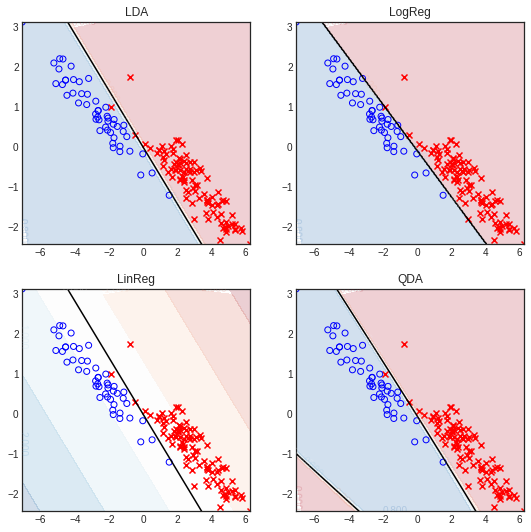

In [14]:
X_train, y_train = data["train_A"][:, 0:2], data["train_A"][:, -1]
X_test, y_test = data["test_A"][:, 0:2], data["test_A"][:, -1]


# Note that by setting some of the entries to None you can implement and test each
# of the methods one by one.

# You can erase the following TWO lines once you are comfortable with the codebase.
# Your classifiers list should always look like this. Run this when you
# have implemented and tested the methods above.

classifiers = [model(X_train, y_train) for model in [LDA, LogReg, LinReg, QDA]]
plot_results(X_train, y_train, classifiers)

#### Comparison


In [15]:
def accuracy(y_true, y_pred):
    return np.equal(y_true, y_pred).mean()

threshold = 0.5
y_pred_train = [f(X_train[:, 0], X_train[:, 1]) >= threshold for f in classifiers]
y_pred_test = [f(X_test[:, 0], X_test[:, 1]) >= threshold for f in classifiers]

acc_train =  [accuracy(y_train, y_p) for y_p in y_pred_train]
print(f"Train: LDA = {acc_train[0]:.4f}, LogReg = {acc_train[1]:.4f}, LinReg = {acc_train[2]:.4f}, QDA = {acc_train[3]:.4f}")
acc_test =  [accuracy(y_test, y_p) for y_p in y_pred_test]
print(f"Test: LDA = {acc_test[0]:.4f}, LogReg = {acc_test[1]:.4f}, LinReg = {acc_test[2]:.4f}, QDA = {acc_test[3]:.4f}")

Train: LDA = 0.9867, LogReg = 1.0000, LinReg = 0.9867, QDA = 0.9933
Test: LDA = 0.9800, LogReg = 0.9660, LinReg = 0.9793, QDA = 0.9800


Method | Train Acc. | Test Acc.
--- | --- | ---
*LDA* | 98.7 % | 98 %
*LogReg* | 100 % | 96.6 %
*LinReg* | 98.7 % | 97.9 %
*QDA* | 99.3 % | 98.1 %

**_Learnt parameters_**
Convention: $\beta_i$ are linear parameters, $\gamma$ is the offset parameter and $A_{ij}$ is the quadratic parameter (for QDA).


  .  | LDA | LogReg | LinReg | QDA
--- |--- | --- | --- | ---
$\beta_0$ | -6.622 | -341.577 | -0.264 | -7.365
$\beta_1$ | -9.346 | -591.516 | -0.373 | -10.873
$\gamma$  | -0.136 | -56.874  | 0.492  | -0.776
$A_{00}$  | | | |  -0.759
$A_{01}$  | | | | -1.514
$A_{10}$  | | | | -1.514 
$A_{11}$  | | | | -2.862

**Question:** Is the misclassiffication error larger, smaller, or similar on the training and test data? Why?

**Answer:**

The misclassification error are smaller than 2% for the training set and for the test set, except for the test score of logistic regression which jumps to 3.4%.

---
This is because the training examples are linearly separable in $\mathbb{R}^2$. The MLE estimators of the linear regression and the LDA algorithm can only approximate this solution, while logistic regression is able to converge to the solution with an unregularized iterative algorithm. 

Since the logistic regression is able to reach the best possible solution given the training data, then it overfit that data and becomes the worst performer on the test set. The other methods perform slightly worst, and they stay close to one another.



**Question:** Which methods yield very similar/dissimilar results? Which method yield the best results? Provide an interpretation.

**Answer:**
Logistic regression, LDA and linear regression all try to linearly separate the data. LDA and linear regression have a very similar probability contour map since they both return a probability density function (sigmoid). 

Linear regression has nearly the same decision boundary as LDA, but its probability contour map is not a probability density function. The fact that it finds the same solution as LDA is linked to the fact that they are both a maximum likelihood solution of order 1 (that is we only search for linear parameter).

QDA's decision boundary is dissimilar to the 3 other method since it is a parabola in the data space. Near the mean of the classes, the parabola is well approximated by a line for this dataset.

---
QDA perform better than LDA on both sets even though the dataset was built with two gaussian of different means and a shared covariance (which are the hypothesis of LDA). 

The misclassification error is smaller by 0.6% and 0.1% on the training and test set respectively. We reason that the small training samples have different class data covariance $\tilde{\Sigma}_{y_i}$ and therefore QDA can provide a better decision boundary on the training set. The difference between LDA and QDA on the test is very small. Since LDA was made with the assumption of a shared covariance, we would espect LDA to outperform QDA on the test set. The very small difference means the decision boundary found by QDA was very similar to LDA which we can appreciate looking at the plots.



### Dataset B

#### Parameter estimation and plots

LDA parameters: beta_0 = -1.921, beta_1 = 0.954, gamma = 0.001
LogReg learnt parameters: w0 = -1.705,  w1 = 1.024, b = 1.350
LinReg learnt parameters: : w0 = -0.104,  w1 = 0.052, b = 0.500
QDA learnt quadratic form matrix: A_00 = -0.480, A_01 = -1.924, A_10 = -1.924, A_11 = -5.529
QDA learnt linear parameters: beta_0 = -2.281, beta_1 = 1.457, gamma = 3.367


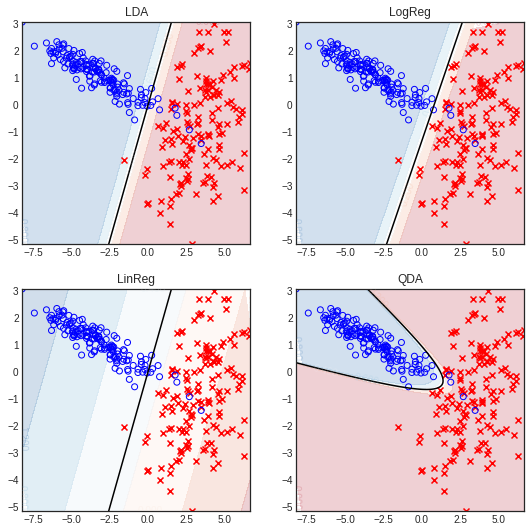

In [16]:
X_train, y_train = data["train_B"][:, 0:2], data["train_B"][:, -1]
X_test, y_test = data["test_B"][:, 0:2], data["test_B"][:, -1]


# Your classifiers list should always look like this. Run this when you
# have implemented and tested the methods above.

classifiers = [model(X_train, y_train) for model in [LDA, LogReg, LinReg, QDA]]
plot_results(X_train, y_train, classifiers)

In [ ]:
y_pred_train = [f(X_train[:, 0], X_train[:, 1]) >= threshold for f in classifiers]
y_pred_test = [f(X_test[:, 0], X_test[:, 1]) >= threshold for f in classifiers]

acc_train =  [accuracy(y_train, y_p) for y_p in y_pred_train]
print(f"Train: LDA = {acc_train[0]:.4f}, LogReg = {acc_train[1]:.4f}, LinReg = {acc_train[2]:.4f}, QDA = {acc_train[3]:.4f}")
acc_test =  [accuracy(y_test, y_p) for y_p in y_pred_test]
print(f"Test: LDA = {acc_test[0]:.4f}, LogReg = {acc_test[1]:.4f}, LinReg = {acc_test[2]:.4f}, QDA = {acc_test[3]:.4f}")

Train: LDA = 0.9700, LogReg = 0.9800, LinReg = 0.9700, QDA = 0.9767
Test: LDA = 0.9585, LogReg = 0.9570, LinReg = 0.9585, QDA = 0.9765


#### Comparison


Method | Train Acc. | Test Acc.
--- | --- | ---
*LDA* | 97 % | 95.9 %
*LogReg* | 98 % | 95.7 %
*LinReg* | 97 % | 95.9 %
*QDA* | 97.7 % | 97.7 %


**_Learnt parameters_**
Convention: $\beta_i$ are linear parameters, $\gamma$ is the offset parameter and $A_{ij}$ is the quadratic parameter (for QDA).


  .  | LDA | LogReg | LinReg | QDA
--- |--- | --- | --- | ---
$\beta_0$ | -1.921 | -1.705  | -0.104  | -2.281
$\beta_1$ | 0.954  | 1.024   |  0.052  | 1.457
$\gamma$  | 0.001  | 1.350   |  0.500   | 1.932
$A_{00}$  | | | |  -0.480
$A_{01}$  | | | |  -1.924
$A_{10}$  | | | |  -1.924
$A_{11}$  | | | |  -5.529


**Question:** Is the misclassiffication error larger, smaller, or similar on the training and test data? Why?

**Answer:**
Classification error in the training set is very similar between QDA and logistic regression (2.3% and 2% respectively), while it is larger for the linear regression and LDA method (3% each).

Logistic regression performs poorly on the test set again.

QDA has the same misclassification error on the test set as it has on the training set, which means it generalizes very well for this dataset. This is expected since the data fits exactly the hypothesis made for QDA. It is the best performer on the test set.

---
We expected QDA to be the best performer since the assumption made in this method fit the intrisic parameter of the data. This is reflected by a very good generalization between the training set and the test set. 

The decision boundary found by linear regression and LDA is pratically the same. Their result are identical on the training set and the test set. Therefore these two method are equivalent in this case.

Logisitic regression is able to improve slightly on LDA and linear regression solutions, at the cost of a worst misclassification error on the test set (0.2% more than other linear methods on test set).





**Question:** Which methods yield very similar/dissimilar results? Which method yield the best results? Provide an interpretation.

**Answer:**

Logistic regression, LDA and linear regression all have very similar decision boundary.
Linear regression and LDA have the exact same solution, while logistic regression have a slightly improved solution.

QDA's decision boundary fit very well the blue points. In that sense, this boundary is better suited to the situation, although this tight fit will lead to misclassification of outliers in the blue region. Therefore, we might say that this QDA is biased (in a lose sense of this word) to predict toward the red class label.

---

QDA provide a much better solution since it is able to use the distinct covariance information to align the boundary to the greatest variance direction for the blue class. 

On the other hand, the linear method can only find a line in the data space to separate the class labels, which does not account for the intrisic structure of the class distributions.


### Dataset C

#### Parameter estimation and plots

LDA parameters: beta_0 = -2.051, beta_1 = -0.273, gamma = 0.112
LogReg learnt parameters: w0 = -2.203,  w1 = 0.709, b = 0.959
LinReg learnt parameters: : w0 = -0.128,  w1 = -0.017, b = 0.508
QDA learnt quadratic form matrix: A_00 = 0.002, A_01 = -0.146, A_10 = -0.146, A_11 = 0.118
QDA learnt linear parameters: beta_0 = -2.665, beta_1 = 0.349, gamma = 0.520


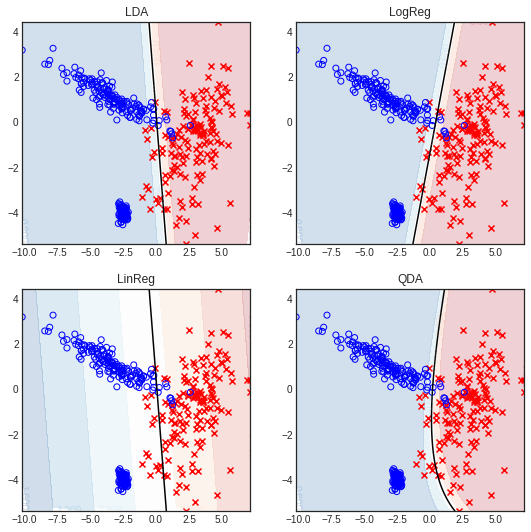

In [ ]:
X_train, y_train = data["train_C"][:, 0:2], data["train_C"][:, -1]
X_test, y_test = data["test_C"][:, 0:2], data["test_C"][:, -1]


# Your classifiers list should always look like this. Run this when you
# have implemented and tested the methods above.

classifiers = [model(X_train, y_train) for model in [LDA, LogReg, LinReg, QDA]]
plot_results(X_train, y_train, classifiers)

#### Comparison


In [ ]:
y_pred_train = [f(X_train[:, 0], X_train[:, 1]) >= threshold for f in classifiers]
y_pred_test = [f(X_test[:, 0], X_test[:, 1]) >= threshold for f in classifiers]

acc_train =  [accuracy(y_train, y_p) for y_p in y_pred_train]
print(f"Train: LDA = {acc_train[0]:.4f}, LogReg = {acc_train[1]:.4f}, LinReg = {acc_train[2]:.4f}, QDA = {acc_train[3]:.4f}")
acc_test =  [accuracy(y_test, y_p) for y_p in y_pred_test]
print(f"Test: LDA = {acc_test[0]:.4f}, LogReg = {acc_test[1]:.4f}, LinReg = {acc_test[2]:.4f}, QDA = {acc_test[3]:.4f}")

Train: LDA = 0.9450, LogReg = 0.9600, LinReg = 0.9450, QDA = 0.9475
Test: LDA = 0.9577, LogReg = 0.9773, LinReg = 0.9577, QDA = 0.9597


Method | Train Acc. | Test Acc.
--- | --- | ---
*LDA* | 94.5 % | 95.8 %
*LogReg* | 96 % | 97.7 %
*LinReg* | 94.5 % | 95.8 %
*QDA* | 94.8 % | 96.0 %


**_Learnt parameters_**
Convention: $\beta_i$ are linear parameters, $\gamma$ is the offset parameter and $A_{ij}$ is the quadratic parameter (for QDA).


  .  | LDA | LogReg | LinReg | QDA
--- |--- | --- | --- | ---
$\beta_0$ | -2.051 | -2.203  | -0.128  | -2.665
$\beta_1$ | -0.273 | 0.709   | -0.017  |  0.349
$\gamma$  | 0.112  | 0.959   | 0.508   |  0.520
$A_{00}$  | | | |  0.002
$A_{01}$  | | | |  -0.146
$A_{10}$  | | | |  -0.146
$A_{11}$  | | | |  0.118


**Question:** Is the misclassiffication error larger, smaller, or similar on the training and test data? Why?

**Answer:**

The misclassification error are large for this dataset. All errors are greater than 4% on the test set. 

The logistic regression performs the best for this dataset, both on the training set and on the test set.

The misclassification errors on the test set are lower for all methods.

---

For QDA, a mixture of gaussian for the blue class means the elements of the covariant matrix estimated are going to be very large. The red class covariant matrix elements are very large as can be seen by the dispersion of red points on the data space.

We see that QDA estimate the difference between these two to be small ($A_{ij}$ parameters are small). In fact, the off diagonal parameters $A_{ij}, i \not = j$ are negative so that the second gaussian for the blue class make the covariant estimate of this class are slightly larger than the red covariance. This is why the QDA decision boundary bends toward the red class, even though blue points is a mixture of two gaussian with a very small variance. 

Since all models underperformed for this data set, then the increase in performance in the test is probably a statistical fluke. The training dataset has less outliers (points far from the class mean) than the training set, and therefore all boundary are somewhat equivalent.

Logistic regression perform better than QDA, LDA and linear regression because it is able to better fit the decision boundary to separate outliers to the mean of the red class. This method is very sensible to outliers, especially ones near the other class. Since LDA and linear regression try to estimate a shared covariance matrix and find the blue points have larger estimated covariance matrix elements, then they tend to give more space to the blue class and sacrifice the outliers in the red class. In other words, they are very sensible to the measured covariance matrix, like QDA.

Therefore, we conclude, the estimated solution from logistic regression, which overfitted the data inb the two previous dataset, is able to find a better solution in this case where assumption made about the intrinsic distribution fails for the other methods.

**Question:** Which methods yield very similar/dissimilar results? Which method yield the best results? Provide an interpretation.

**Answer:**

Both LDA and linear regression find the same decision boundary. Logistic regression find the best solution, which is angled diffrently than LDA and LR. 

QDA find a solution _biased_ toward blue points similarly to LDA and LR.

---

We find that Logistic regression is able to find a larger bias term $\gamma = 0.959$ to the other methods thanks to the iterated convergence to the solution. This means it fits a better decision boundary to separate training data. 

We conclude that the logistic regression is less sensible to the initial assumptions made about the intrinsic distribution of the data than the other methods.